In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore') 

# Update rcParams in mpl
rcParams = {
        'font.size': 20,                # all fonts-size in plot
        'font.weight': 'bold',          # bold all fonts
        'figure.titleweight': 'bold',   # bold supertitle
        'axes.linewidth' : 6,
        'xtick.major.width': 6,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'lines.linewidth': 6,
        'legend.fontsize': 'large',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
        'xtick.labelsize': 20,   # sets x-tick font size
        'ytick.labelsize': 20,
        'axes.titlepad': 20,   # spacing between suptitle and figure
        'axes.facecolor': 'white'
    }

from adhoc_analysis import Adhoc
from CycloidConnector import VWCycloid 

# Lets initialize the Adhoc class
adhoc = Adhoc()

# print all available methods in adhoc
#print([method for method in dir(adhoc) if not method.startswith('__')])

# Lets initialize VWCycloid class
redshift = VWCycloid() 

## Time at each recipe step

In [124]:
data = pd.read_csv("testRemotePack_fast.csv", usecols = [
'doe', 'instance', 'cycle_num', 'charging_state_name', 'elapsed_minutes', 'avg_current_a',
'avail_battery_capacity_ah', 'avg_voltage_v', 'cccv_state'
]).query("charging_state_name == 'CHARGE'").reset_index(drop = True)

In [125]:
data.instance.unique()

array(['d49', 'd50', 'd63', 'd65', 'd67', 'd68', 'd69', 'd72'],
      dtype=object)

In [126]:
def get_step_time(df, current_threshold = 1.0, sigma_multiplier = 3.0, window = 200):
    # Copy the df
    data = df.copy()

    # If data is empty return empty DataFrames
    if data.empty:
        return pd.DataFrame(), pd.DataFrame()
    
    # Find the time to CV state
    if data.loc[data['cccv_state'].eq(2)].empty:
        return pd.DataFrame(), pd.DataFrame()
    
    cc_time = data.loc[data['cccv_state'].eq(2).idxmax(), 'elapsed_minutes']
    cv_time = data['elapsed_minutes'].max() - cc_time


    # Cut off data before CV period starts
    df = df[df['elapsed_minutes'].between(0, cc_time)]\
        .dropna(subset=['avg_current_a']).reset_index(drop = True)

    # Make sure initial currents are close to 0 (or what it should be)
    df.loc[df.elapsed_minutes < 1.0, 'avg_current_a'] = df[df.elapsed_minutes < 1.0].avg_current_a.median()

     # Create a desired result DataFrame
    result = pd.DataFrame()
    doe = df['doe'].unique()[0]
    cycle_num = df['cycle_num'].unique()[0]
    instance = df['instance'].unique()[0]
    charging_state_name = ['CHARGE']

    # Since we need to handle outliers and avg_current_a contain np.nan values

    def outlier_handler(series: pd.Series, sigma_multiplier : float = sigma_multiplier, window = window) -> pd.Series:
        """
        Handle outliers in a pandas Series.

        Parameters:
            series (pd.Series): The input Series.
            sigma_multiplier (float): Defines the boundary for outliers.

        Returns:
            pd.Series: Series with outliers handled.
        """
        roll = series.rolling(window = window, min_periods = 1)
        md = roll.median()
        sd = roll.std(ddof = 0)
        z_score = (series - md) / sd
        series[(z_score < - sigma_multiplier) | (z_score > sigma_multiplier)] = md
        return series
    
    # Lets define a new DataFrame
    current_df = df[['elapsed_minutes', 'avg_current_a']].dropna().reset_index(drop = True)

    # Handle outliers in avg_current_a
    current_df['avg_current_a'] = outlier_handler(current_df['avg_current_a'])

    # Identify where the current step occurs
    current_df['delta_current'] = current_df['avg_current_a'].diff().abs()

    # Identify step changes
    step_changes = current_df[current_df['delta_current'] > current_threshold]

    # Get the original dataframe indices where steps change occur
    # Add first and last index as well
    indices = [0] + step_changes.index.to_list() + [len(df) - 1]

    m = len(indices) - 1

    result['doe'] = [doe] * m
    result['instance'] = [instance] * m
    result['cycle_num'] = [cycle_num] * m
    result['charging_state_name'] = charging_state_name * m
    result['step_avg_current_a'] = [current_df.loc[indices[i]:indices[i+1], 'avg_current_a'].median() for i in range(m)]
    result['step_time_length_min'] = [current_df.loc[indices[i]:indices[i+1],
    'elapsed_minutes'].max() - current_df.loc[indices[i]:indices[i+1], 'elapsed_minutes'].min() for i in range(m)]

    # Calculate voltage and capacity exactly at the time frames
    time_steps = [0] + result['step_time_length_min'].cumsum().to_list()
    time_steps.append(data['elapsed_minutes'].max())

    # Get the exact voltage values at the time frames
    voltage_values = []
    voltage_values.append(data.loc[data['avg_voltage_v'].first_valid_index(), 'avg_voltage_v'])
    for i in range(len(time_steps) - 1):
        voltage_values.append(data[data['elapsed_minutes'].between(time_steps[i], time_steps[i + 1])]['avg_voltage_v'].max())

    voltage_ranges = [(voltage_values[i], voltage_values[i + 1]) for i in range(len(voltage_values) - 1)]

    # Get the exact capacity values at the time frames
    capacity_values = []
    capacity_values.append(data.loc[data['avail_battery_capacity_ah'].first_valid_index(), 'avail_battery_capacity_ah'])
    for i in range(len(time_steps) - 1):
        capacity_values.append(data[data['elapsed_minutes'].between(time_steps[i], time_steps[i + 1])]['avail_battery_capacity_ah'].max())

    capacity_ranges = [(capacity_values[i], capacity_values[i + 1]) for i in range(len(capacity_values) - 1)]

    result['min_avg_voltage_v'] = [voltage[0] for voltage in voltage_ranges[:-1]]
    result['max_avg_voltage_v'] = [voltage[1] for voltage in voltage_ranges[:-1]]
    result['min_capacity_ah'] = [capacity[0] for capacity in capacity_ranges[:-1]]
    result['max_capacity_ah'] = [capacity[1] for capacity in capacity_ranges[:-1]]

    # Add CV period data for completeness
    result.loc[len(result)] = [
        doe, instance, cycle_num, charging_state_name[0], 'cv_current', cv_time, 
        voltage_ranges[-1][0],
        voltage_ranges[-1][1],
        capacity_ranges[-1][0],
        capacity_ranges[-1][1]
    ]

    # Drop rows where time < 0.2
    result = result[result['step_time_length_min'] > 0.2].reset_index(drop = True)

    # If time_steps are less than a minute, please ask the user to decrease or increase the window size
    message_printed = False
    if any(result['step_time_length_min'] < 1.0):
        if not message_printed:
            print("Some current steps are short lived than 1.0 minutes, you may want to increase or decrease the window size to address that issue.")
            print(result[result['step_time_length_min'] < 1.0][['doe', 'instance', 'cycle_num', 'step_avg_current_a', 'step_time_length_min']])
            print("**********************************************************************************************************************************")
        message_printed = True
    return result, current_df

In [127]:
store = []
instance_cycle = [(i, j) for i in ['d49', 'd50', 'd63', 'd65', 'd67', 'd68', 'd69', 'd72'] for j in range(2, 5)]

for instance, cycle in instance_cycle:
    test = data[(data['instance'] == instance) & (data['cycle_num'] == cycle)]
    times = get_step_time(test, window = 100, current_threshold = 1.0)[0]
    store.append(times)

result_df = pd.concat(store, axis = 0)

In [128]:
result_df

,doe,instance,cycle_num,charging_state_name,step_avg_current_a,step_time_length_min,min_avg_voltage_v,max_avg_voltage_v,min_capacity_ah,max_capacity_ah
0,testRemotePack,d49,2,CHARGE,0.0,15.817700,16.300613,16.621567,0.000003,0.005152
1,testRemotePack,d49,2,CHARGE,-3.371109,9.131100,16.621567,18.496552,0.005152,0.529843
2,testRemotePack,d49,2,CHARGE,-9.108475,6.092033,18.496552,19.467834,0.529843,1.463851
3,testRemotePack,d49,2,CHARGE,-15.299652,9.873717,19.467834,20.836075,1.463851,3.935500
4,testRemotePack,d49,2,CHARGE,cv_current,16.523233,20.836075,21.081009,3.935500,5.561428
...,...,...,...,...,...,...,...,...,...,...
0,testRemotePack,d72,4,CHARGE,0.0,18.154600,17.189972,17.680878,0.000003,0.002344
1,testRemotePack,d72,4,CHARGE,-3.384644,8.981017,17.680878,18.933517,0.002344,0.520026
2,testRemotePack,d72,4,CHARGE,-9.112503,6.060950,18.933517,19.974564,0.520026,1.453783
3,testRemotePack,d72,4,CHARGE,-15.393616,3.954450,19.974564,20.558563,1.453783,2.472077


In [129]:
result_df.dropna(subset = ['min_avg_voltage_v','max_avg_voltage_v', 'min_capacity_ah', 'max_capacity_ah']).\
to_excel("test_fast.xlsx", index = False)

In [130]:
# Make sure the charge time before and after are same
result_df.groupby(['doe', 'instance', 'cycle_num', 'charging_state_name'])['step_time_length_min'].sum().reset_index(name = 'charge time')

,doe,instance,cycle_num,charging_state_name,charge time
0,testRemotePack,d49,2,CHARGE,57.437783
1,testRemotePack,d49,3,CHARGE,57.574017
2,testRemotePack,d49,4,CHARGE,58.014967
3,testRemotePack,d50,2,CHARGE,58.875100
4,testRemotePack,d50,3,CHARGE,58.237600
5,testRemotePack,d50,4,CHARGE,58.113117
6,testRemotePack,d63,2,CHARGE,56.469083
7,testRemotePack,d63,3,CHARGE,57.355167
8,testRemotePack,d63,4,CHARGE,57.538717
9,testRemotePack,d65,2,CHARGE,57.603933


In [131]:
data[(data['charging_state_name'] == 'CHARGE')].groupby\
(['doe', 'instance', 'cycle_num', 'charging_state_name'])['elapsed_minutes'].max().reset_index(name = 'charge time')

,doe,instance,cycle_num,charging_state_name,charge time
0,testRemotePack,d49,2,CHARGE,57.442717
1,testRemotePack,d49,3,CHARGE,57.578950
2,testRemotePack,d49,4,CHARGE,58.019900
3,testRemotePack,d50,2,CHARGE,58.880033
4,testRemotePack,d50,3,CHARGE,58.242383
5,testRemotePack,d50,4,CHARGE,58.118133
6,testRemotePack,d63,2,CHARGE,56.473850
7,testRemotePack,d63,3,CHARGE,57.359933
8,testRemotePack,d63,4,CHARGE,57.543633
9,testRemotePack,d65,2,CHARGE,57.608867


## Cycloid Data

## testPackFultonv670

In [3]:
v670 = redshift.get_cycloid_data(doe = 'testRemotePack', instances= [44, 45, 46, 47, 48, 49], default_columns = True)

Status: PICKED
Status: FINISHED
QUERY FINISHED.


Aggregating Results for DoE testPackFultonv670: 100%|██████████| 172/172 [00:00<00:00, 279.97lines/s]


Frame created successfuly.


In [4]:
v670 = v670.query("(cycling_substate.isin(['CHARGE', 'CHARGE REST', 'DISCHARGE', 'DISCHARGE REST', 'DCIR'])) & (cycle.between(2, 5))")\
[['doe_number', 'instance_number', 'cycle', 'cycling_substate', 'time', 'capacity', 'energy', 'energy_rest']]

In [5]:
maps = {44: '44_60min', 45: '45_60min', 46: '46_65min', 47: '47_65min', 48: '48_70min', 49: '49_70min'}
v670['instance_time'] = v670['instance_number'].map(maps)

In [6]:
ctime = v670[v670['cycling_substate'] == 'CHARGE']
charge_time = ctime.groupby('instance_number')['time'].agg('median').apply(int).reset_index(name = 'median_time')
maps = dict(zip(charge_time['instance_number'], charge_time['instance_number'].astype(str) + '_' + charge_time['median_time'].astype(str) + 'min'))
ctime['instance_time'] = ctime['instance_number'].map(maps)

In [7]:
dis_energy = adhoc.get_discharge_energy(v670)
dis_energy['instance_time'] = dis_energy['instance_number'].map(maps)

Text(0, 0.5, 'Discharge Energy [Wh]')

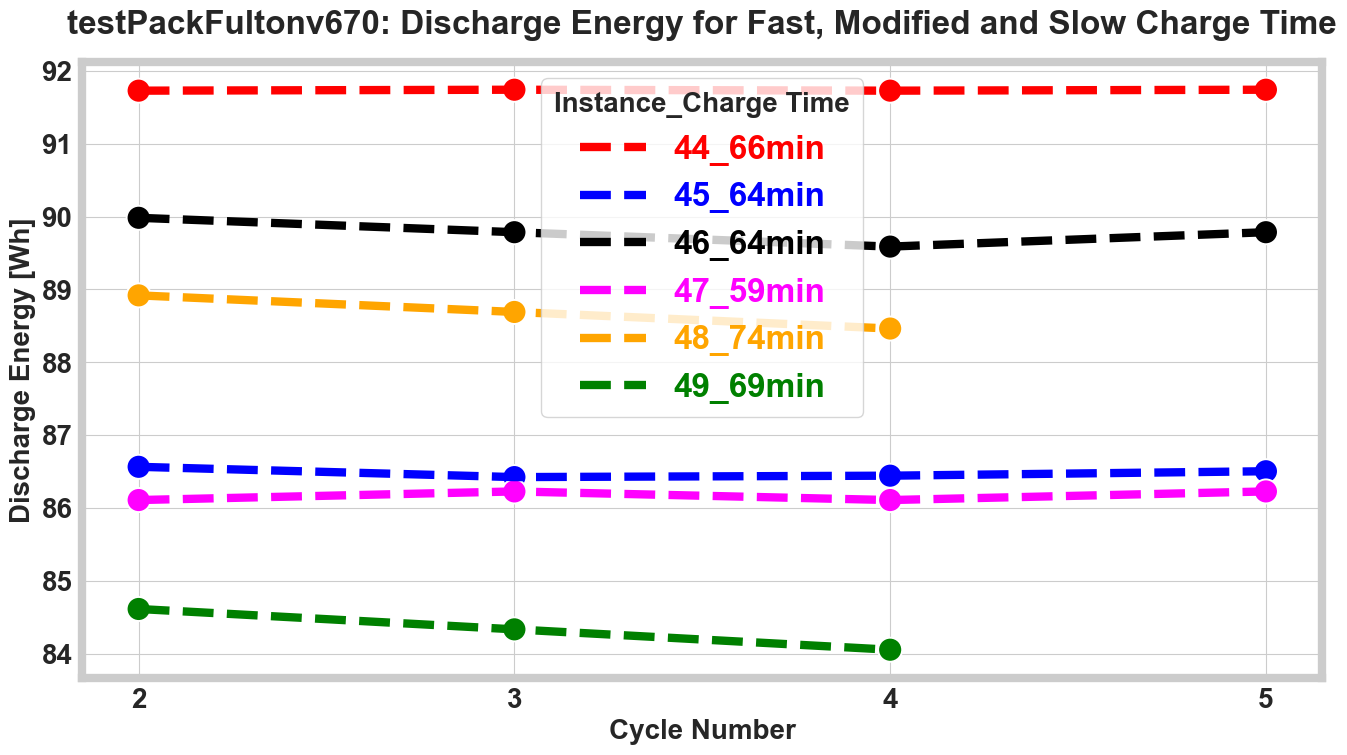

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize = (16, 8))
unique_hues = len(dis_energy.instance_number.unique())
palette = ['red', 'blue', 'black', 'magenta', 'orange', 'green', 'navy', 'gray'][:unique_hues]
sns.lineplot(data = dis_energy, x = 'cycle', y = 'discharge_energy', hue = 'instance_time', palette = palette, linestyle = '--')
sns.scatterplot(data = dis_energy, x = 'cycle', y = 'discharge_energy', hue = 'instance_time', palette = palette, markers= True, s = 300, legend = False)
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.legend(labelcolor = 'linecolor', title = 'Instance_Charge Time')
plt.title("testPackFultonv670: Discharge Energy for Fast, Modified and Slow Charge Time", fontweight = 'bold')
plt.xlabel("Cycle Number")
plt.ylabel("Discharge Energy [Wh]")

In [9]:
ctime = v670[v670['cycling_substate'] == 'CHARGE']
charge_time = ctime.groupby('instance_number')['time'].agg('median').apply(int).reset_index(name = 'median_time')
maps = dict(zip(charge_time['instance_number'], charge_time['instance_number'].astype(str) + '_' + charge_time['median_time'].astype(str) + 'min'))
ctime['instance_time'] = ctime['instance_number'].map(maps)

Text(0, 0.5, 'Charge Time [min]')

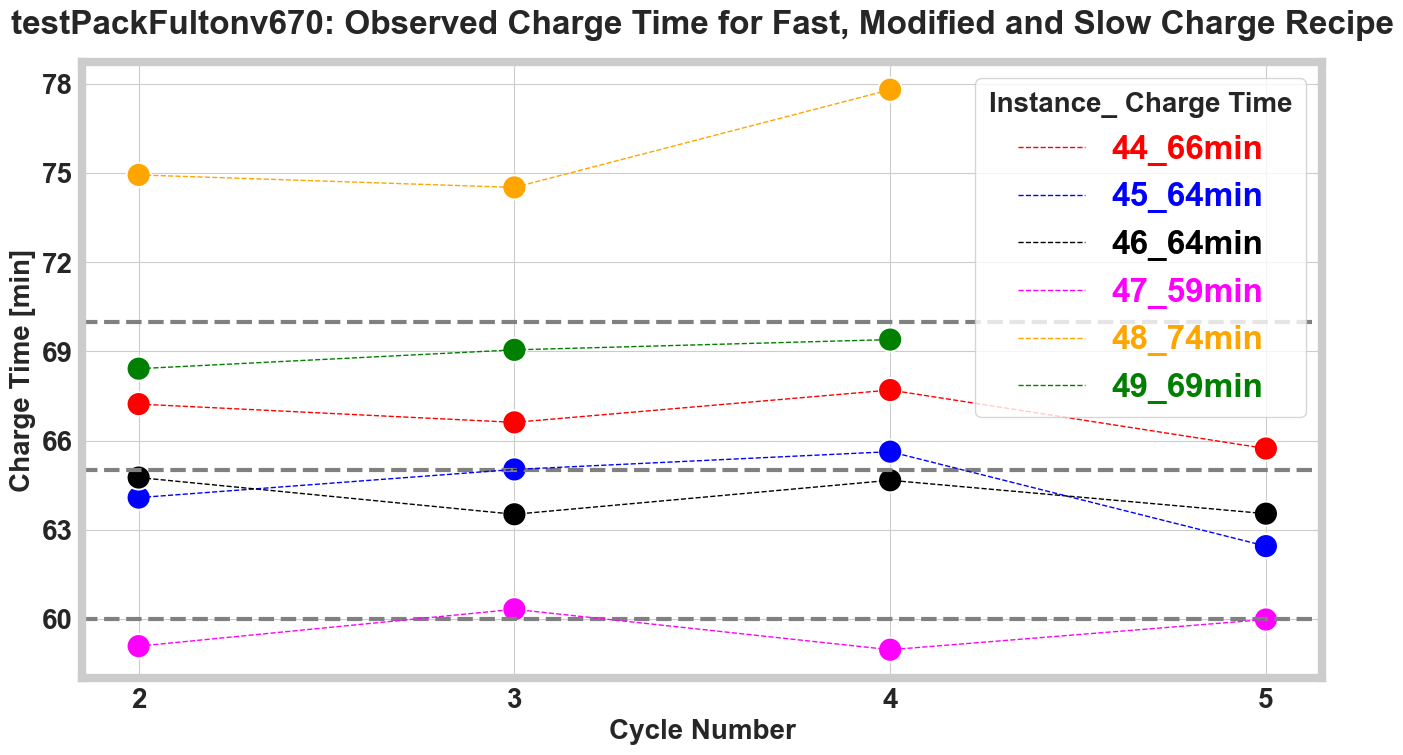

In [12]:
sns.set_style("whitegrid")
from matplotlib.ticker import MaxNLocator
plt.figure(figsize = (16, 8))
unique_hues = len(ctime.instance_number.unique())
palette = ['red', 'blue', 'black', 'magenta', 'orange', 'green', 'navy', 'gray'][:unique_hues]
for time in [60, 65, 70]:
    plt.axhline(time, linestyle = '--', color = 'gray', linewidth = 3.0)
sns.lineplot(data = ctime, x = 'cycle', y = 'time', hue = 'instance_time', palette = palette, linestyle = '--', linewidth = 1.0)
sns.scatterplot(data = ctime, x = 'cycle', y = 'time', hue = 'instance_time', palette = palette, markers= True, s = 300, legend = False)
plt.legend(labelcolor = 'linecolor', title = 'Instance_ Charge Time')
plt.title("testPackFultonv670: Observed Charge Time for Fast, Modified and Slow Charge Recipe", fontweight = 'bold')
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.xlabel("Cycle Number")
plt.ylabel("Charge Time [min]")

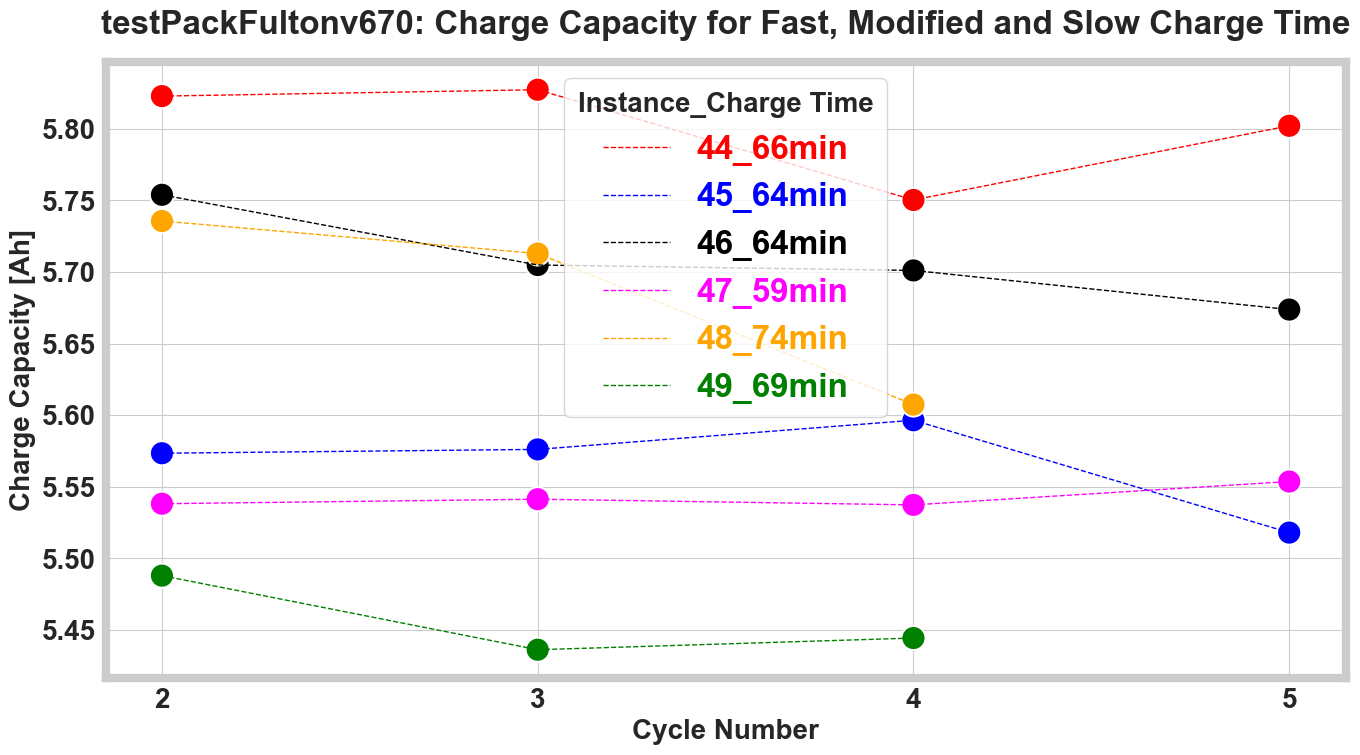

In [11]:
sns.set_style("whitegrid")
from matplotlib.ticker import MaxNLocator
plt.figure(figsize = (16, 8))
unique_hues = len(ctime.instance_number.unique())
palette = ['red', 'blue', 'black', 'magenta', 'orange', 'green', 'navy', 'gray'][:unique_hues]
sns.lineplot(data = ctime, x = 'cycle', y = 'capacity', hue = 'instance_time', palette = palette, linestyle = '--', linewidth = 1.0)
sns.scatterplot(data = ctime, x = 'cycle', y = 'capacity', hue = 'instance_time', palette = palette, markers= True, s = 300, legend = False)
plt.legend(labelcolor = 'linecolor', title = 'Instance')
plt.title("testPackFultonv670: Charge Capacity for Fast, Modified and Slow Charge Time", fontweight = 'bold')
plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
plt.xlabel("Cycle Number")
plt.ylabel("Charge Capacity [Ah]")
plt.legend(labelcolor = 'linecolor', title = 'Instance_Charge Time')

# testRemotePack

In [15]:
remote = redshift.get_cycloid_data(doe = 'testRemotePack', default_columns = True)

Status: PICKED
Status: STARTED
Status: FINISHED
QUERY FINISHED.


Aggregating Results for DoE testRemotePack: 100%|██████████| 12409/12409 [00:08<00:00, 1546.23lines/s]


Frame created successfuly.


In [16]:
modified = [f'd{i}' for i in range(49, 51)] + [f'd{i}' for i in range(61, 73)]
fast = [f'e{i}' for i in range(49, 51)] + [f'e{i}' for i in range(61, 73) if i not in (62, 64, 70)]
slow = [f'f{i}' for i in range(49, 51)] + [f'f{i}' for i in range(61, 73) if i not in (62, 64, 70, 71)]
desired = modified + fast + slow

remotepack = remote.query(f"(cycling_substate.isin(['CHARGE', 'CHARGE REST', 'DISCHARGE', 'DISCHARGE REST', 'DCIR'])) & (cycle >= 2) & (instance_number.isin({desired}))")\
[['doe_number', 'instance_number', 'cycle', 'cycling_substate', 'time', 'capacity', 'energy', 'energy_rest']]

In [17]:
maps = {i: 'fast_60min' for i in fast}
maps.update({i: 'modified_65min' for i in modified})
maps.update({i: 'slow_70min' for i in slow})

In [18]:
cremotepack = remotepack[(remotepack['cycling_substate'] == 'CHARGE') & (remotepack['time'] >= 52.0)].reset_index(drop = True)
cremotepack['recipe'] = cremotepack['instance_number'].map(maps)

In [19]:
grouped_time = cremotepack.groupby('instance_number').agg({'time':['median', 'std']}).reset_index()
grouped_time.columns = grouped_time.columns.droplevel(-1)
grouped_time.columns = ['instance_number', 'median_time', 'std_time']
for i, std_time in enumerate(grouped_time['std_time']):
    if std_time is None or np.nan:
        grouped_time['std_time'] = grouped_time.loc[i, 'median_time'] * 0.02
grouped_time['lower_time'] = grouped_time['median_time'] - 3.0 * grouped_time['std_time']

In [20]:
grouped_time[grouped_time['instance_number'] == 'd49']['lower_time'].values[0]

53.989723999999995

In [21]:
store = []
instances = grouped_time['instance_number'].unique()
for instance_number in instances:
    store.append(cremotepack[(cremotepack['instance_number'] == instance_number) & (cremotepack['time'] > grouped_time[grouped_time['instance_number'] == instance_number]['lower_time'].values[0])])
clean_cremotepack = pd.concat(store)

In [22]:
clean_cremotepack

,doe_number,instance_number,cycle,cycling_substate,time,capacity,energy,energy_rest,recipe
0,testRemotePack,d49,2,CHARGE,57.442717,5.561461,110.949444,NaN,modified_65min
1,testRemotePack,d49,3,CHARGE,57.578950,5.560051,110.979549,NaN,modified_65min
2,testRemotePack,d49,4,CHARGE,58.019900,5.559903,111.014024,NaN,modified_65min
3,testRemotePack,d49,5,CHARGE,59.076033,5.554516,110.843498,NaN,modified_65min
4,testRemotePack,d50,2,CHARGE,58.880033,5.124149,102.725663,NaN,modified_65min
...,...,...,...,...,...,...,...,...,...
102,testRemotePack,f69,3,CHARGE,57.419283,5.378637,106.971934,NaN,slow_70min
103,testRemotePack,f69,4,CHARGE,58.555083,5.337733,106.127080,NaN,slow_70min
104,testRemotePack,f72,2,CHARGE,63.476217,4.739973,94.454927,NaN,slow_70min
105,testRemotePack,f72,3,CHARGE,63.627300,4.642382,92.564166,NaN,slow_70min


Text(0.5, 1.0, 'Charge Capacity for Slow, Modified and Fast Recipe')

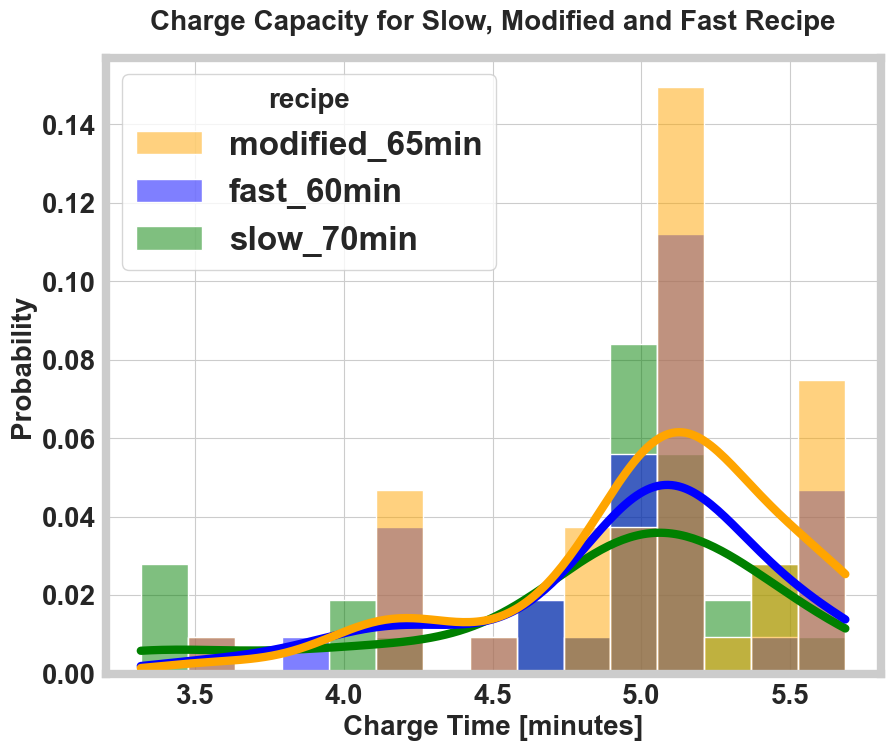

In [39]:
plt.figure(figsize = (10, 8))
sns.histplot(data = clean_cremotepack, x = 'capacity', hue = 'recipe', palette = ['orange', 'blue', 'green'], kde = True, stat = 'probability')
plt.xlabel("Charge Time [minutes]")
plt.title("Charge Capacity for Slow, Modified and Fast Recipe", fontsize = 20, fontweight = 'bold')

In [526]:
f_instances = [instance for instance in clean_cremotepack.instance_number.unique() if 'f' in instance]
d_instances = [instance.replace('f', 'd') for instance in f_instances]
e_instances = [instance.replace('f', 'e') for instance in f_instances]
pairs_de = list(zip(d_instances, e_instances))
pairs_df = list(zip(d_instances, f_instances))
pairs_ef = list(zip(e_instances, f_instances))

In [530]:
store = []
for pair in pairs_de:
    s = pd.DataFrame()
    data = clean_cremotepack[clean_cremotepack['instance_number'].isin(pair)]
    s[['cycle', 'delta']] = data.groupby(['cycle'])['time'].apply(lambda x: x.max() - x.min() if len(x) == 2 else np.nan).reset_index().values
    s['pair'] = [pair] * len(s)
    store.append(s)

delta = pd.concat(store).dropna().reset_index(drop = True)
agg1 = delta.groupby('pair')['delta'].agg(['median', 'mean', 'std']).reset_index()

In [531]:
store = []
for pair in pairs_ef:
    s = pd.DataFrame()
    data = clean_cremotepack[clean_cremotepack['instance_number'].isin(pair)]
    s[['cycle', 'delta']] = data.groupby(['cycle'])['time'].apply(lambda x: x.max() - x.min() if len(x) == 2 else np.nan).reset_index().values
    s['pair'] = [pair] * len(s)
    store.append(s)

delta = pd.concat(store).dropna().reset_index(drop = True)
agg2 = delta.groupby('pair')['delta'].agg(['median', 'mean', 'std']).reset_index()

In [532]:
store = []
for pair in pairs_df:
    s = pd.DataFrame()
    data = clean_cremotepack[clean_cremotepack['instance_number'].isin(pair)]
    s[['cycle', 'delta']] = data.groupby(['cycle'])['time'].apply(lambda x: x.max() - x.min() if len(x) == 2 else np.nan).reset_index().values
    s['pair'] = [pair] * len(s)
    store.append(s)

delta = pd.concat(store).dropna().reset_index(drop = True)
agg3 = delta.groupby('pair')['delta'].agg(['median', 'mean', 'std']).reset_index()

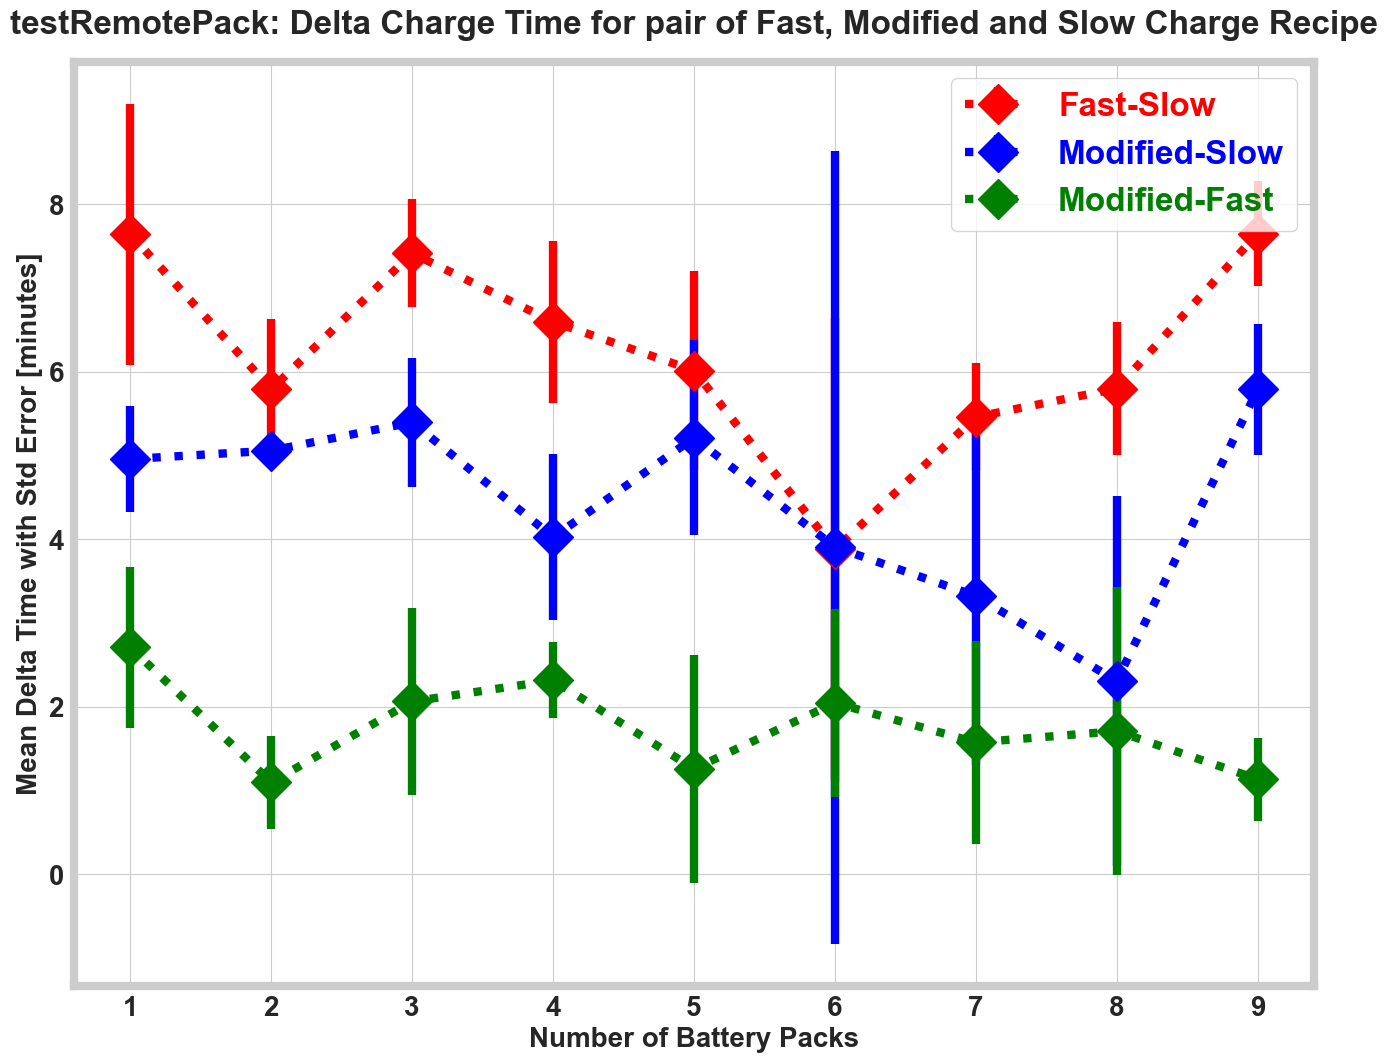

In [538]:
plt.figure(figsize = (16, 12))
plt.errorbar(x = agg2.index + 1,y = agg2['median'] , yerr = agg2['std'],
            marker='D', markersize = 20,
            linestyle= 'dotted', color = 'red', label = 'Fast-Slow')
plt.errorbar(x = agg3.index + 1,y = agg3['median'] , yerr = agg3['std'],
            marker='D', markersize = 20,
            linestyle= 'dotted', color = 'blue', label = 'Modified-Slow')
plt.errorbar(x = agg1.index + 1,y = agg1['median'] , yerr = agg1['std'],
            marker='D', markersize = 20,
            linestyle= 'dotted', color = 'green', label = 'Modified-Fast')
plt.ylabel("Mean Delta Time with Std Error [minutes]")
plt.xlabel("Number of Battery Packs")
plt.title("testRemotePack: Delta Charge Time for pair of Fast, Modified and Slow Charge Recipe", fontweight = 'bold')
plt.legend(labelcolor = 'linecolor')